In [380]:
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tensorboard import SummaryWriter

import matplotlib.pyplot as plt

import os

import inferno
from inferno.utils import to_numpy

from sine_data import train_dataset, valid_dataset
import insp

In [381]:
import visdom
vis = visdom.Visdom()

In [382]:
X_train, y_train = train_dataset()
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset()
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

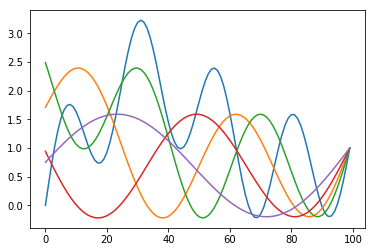

In [383]:
for x in X_train: plt.plot(x.numpy())

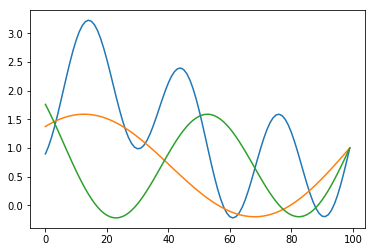

In [384]:
for x in X_valid: plt.plot(x.numpy())

## Components

(0, 1)

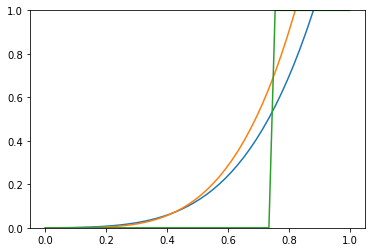

In [5]:
x = np.linspace(0,1)
plt.plot(x, 3/2 * x**4 + 1/8 * x**2)
plt.plot(x, 2.2 * x**4 )
plt.plot(x, x >= 0.75)
plt.ylim([0,1])

In [6]:
class Latch(nn.Module):

    def __init__(self, size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.act = nn.Hardtanh(min_val=0, max_val=1)
        #self.consent_threshold = 0.75
        self.size = size
        
    def initial_q(self, batch_size):
        q = torch.zeros((batch_size, self.size))
        return Variable(q)

    def t(self, s):
        # all inputs in s must say 'store' or otherwise
        # there is no consent to store an value.
        #
        # we want that 
        # - most of the inputs agree
        # - the result is between 0 and 1 so we can use it as gate
        # - we want it to be differentiable and soft (well behaved gradients)
        x = s.sum(-1) / s.size(-1)
        return self.act(3/2 * x**4 + 1/8 * x**2)
        #return (self.act(s).mean(-1) >= self.consent_threshold).float()

    def forward(self, s, v, q):
        t = self.t(s).unsqueeze(-1)
        new_q = v * t + q * (1 - t)
        return new_q

In [7]:
class Block(nn.Module):
    def __init__(self, input_dim, output_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_units = output_dim

        self.latch_size = self.num_units
        self.latch = Latch(self.latch_size)

        self.units = nn.Linear(input_dim, output_dim)
        self.memory = nn.Linear(self.latch_size, self.num_units)
        self.value = nn.Linear(self.num_units, self.latch_size)

        self.act = nn.Tanh()

    def forward(self, x):
        # x.shape = (b, t, u)
        t = x.size(1)
        acts = []
        qs = []
        q = self.latch.initial_q(x.size(0))
        for ti in range(t):
            u = self.units(x[:,ti])
            v = u + self.memory(q)
            q = self.latch(u, self.value(v), q)
            acts += [self.act(v)]
            qs += [q]
        return torch.stack(acts, dim=1), torch.stack(qs, dim=1)

In [8]:
class BlockLayer(nn.Module):
    def __init__(self, num_blocks, input_dim, output_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_blocks = num_blocks
        self.units_per_block = output_dim // num_blocks
        self.blocks = [Block(input_dim=input_dim,
                             output_dim=self.units_per_block)
                       for _ in range(num_blocks)]
        for i in range(len(self.blocks)):
            self.add_module('block_{}'.format(i), self.blocks[i])

    def forward(self, x):
        results = [block(x) for block in self.blocks]
        acts = [n[0] for n in results]
        qs = [n[1] for n in results]
        return torch.cat(acts, dim=-1), torch.cat(qs, dim=-1)

In [357]:
class VectorLatch(nn.Module):
    def __init__(self, size, num_latches, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_latches = num_latches
        self.size_per_latch = size // num_latches
        self.act = nn.Hardtanh(min_val=0, max_val=1)
        #self.consent_threshold = 0.75
        self.size = size
        
    def initial_q(self, batch_size):
        q = torch.zeros((batch_size, self.size))
        return Variable(q)

    def t(self, s):
        # all inputs in s must say 'store' or otherwise
        # there is no consent to store an value.
        #
        # we want that 
        # - most of the inputs agree
        # - the result is between 0 and 1 so we can use it as gate
        # - we want it to be differentiable and soft (well behaved gradients)
        x = s.sum(-1, keepdim=True) / s.size(-1)
        return self.act(3/2 * x**4 + 1/8 * x**2).expand_as(s).contiguous()
        #return (self.act(s).mean(-1) >= self.consent_threshold).float()

    def forward(self, s, v, q):
        s_latch = s.view(-1, self.num_latches, self.size_per_latch)
        t = self.t(s_latch)
        t = t.view(-1, self.size)
        
        new_q = v * t + q * (1 - t)
        return new_q

In [358]:
class VectorBlockLayer(nn.Module):
    def __init__(self, num_blocks, input_dim, output_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.num_blocks = num_blocks
        self.num_units = output_dim

        self.latch_size = self.num_units
        self.latch = VectorLatch(self.latch_size, self.num_blocks)

        self.units = nn.Linear(input_dim, output_dim)
        self.memory = nn.Linear(self.latch_size, self.num_units)
        self.value = nn.Linear(self.num_units, self.latch_size)

        self.act = nn.Tanh()

    def forward_block(self, x):
        # x.shape = (b, t, u)
        t = x.size(1)
        acts = []
        qs = []
        q = self.latch.initial_q(x.size(0))
        for ti in range(t):
            u = self.units(x[:,ti])
            v = u + self.memory(q)
            #q = self.latch(u, self.value(v), q)
            q = self.latch(u, self.value(v), q)
            acts += [self.act(v)]
            qs += [q]
        return torch.stack(acts, dim=1), torch.stack(qs, dim=1)

    def forward(self, x):
        act, q = self.forward_block(x)
        return act, q

## Model

In [359]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

# Sine Wave Reconstruction

In [361]:
class ReconBlockModel(nn.Module):
    def __init__(
        self, 
        *args, 
        baseline=False, 
        writer=None, 
        has_memory=True, 
        vectorized=True, 
        num_hidden=20,
        num_blocks=10,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        
        self.writer = writer
        self.baseline = baseline
        
        if not self.baseline:
            self.has_memory = has_memory
            self.baseline = baseline

            if vectorized:
                self.layer0_mem = VectorBlockLayer(num_blocks=num_blocks,
                                                   input_dim=1,
                                                   output_dim=num_hidden)
            else:
                self.layer0_mem = BlockLayer(num_blocks=num_blocks,
                                             input_dim=1,
                                             output_dim=num_hidden)
            # curve x + memory as inputs
            self.layer0_clf = nn.Linear(1 + num_hidden, num_hidden)
        else:
            self.gru = nn.GRU(1, num_hidden)
            
        self.layer1 = nn.Linear(num_hidden, 1)    
        self.iter = 0

    def forward(self, x):
        if not self.baseline:
            o0, q0 = self.layer0_mem(x)
            
            if self.writer:
                self.writer.add_histogram('q0', q0.data.cpu().numpy(), self.iter)
                self.iter += 1
                
            vis.heatmap(q0[0].data.numpy(), win="foo")
            
            q0 *= int(self.has_memory)
            
            merged0 = torch.cat([x, q0], dim=-1)
            l0_clf = self.layer0_clf(time_flatten(merged0))
        else:
            l0_clf = time_flatten(self.gru(x)[0])
            q0 = 0
        
        l1 = self.layer1(l0_clf)
        
        return time_unflatten(l1, x.size()), q0

In [362]:
class ReconTrainer(inferno.NeuralNet):
    
    def __init__(self, 
                 criterion=nn.MSELoss,
                 writer=None,
                 *args, 
                 **kwargs):
        self.iter = 0
        self.writer = writer
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)
    
    def infer(self, *args, **kwargs):
        ret = super().infer(*args, **kwargs)
        return ret[0]
    
    def train_step(self, *args, **kwargs):
        for name, param in self.module_.named_parameters():
            if self.writer:
                writer.add_histogram(name, param.data.cpu().numpy(), self.iter)
        self.iter += 1
        return super().train_step(*args, **kwargs)

## Training

In [363]:
torch.manual_seed(42)

In [376]:
def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef = ReconTrainer(module=ReconBlockModel,
             optim=torch.optim.RMSprop,
             lr=0.005,
             max_epochs=30,
             train_split=my_train_split,

             module__baseline=False,
             module__vectorized=True,
             module__has_memory=True,
                  
             module__num_blocks=10,
             module__num_hidden=20,

            )

In [377]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0606        1.7649  0.2933
      2        1.7897        1.2723  0.3003
      3        1.3265        0.5367  0.2829
      4        0.5397        0.3115  0.3131
      5        0.3103        0.1740  0.3786
      6        0.1692        0.0962  0.2945
      7        0.0961        0.0524  0.2852
      8        0.0538        0.0325  0.2826
      9        0.0367        0.0284  0.2791
     10        0.0308        0.0232  0.2727
     11        0.0280        0.0252  0.3805
     12        0.0264        0.0217  0.3232
     13        0.0267        0.0253  0.3161
     14        0.0256        0.0223  0.2539
     15        0.0272        0.0238  0.3326
     16        0.0239        0.0200  0.3478
     17        0.0243        0.0199  0.2828
     18        0.0205        0.0163  0.3343
     19        0.0198        0.0165  0.2691
     20        0.0176        0.0139

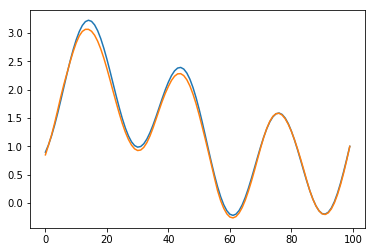

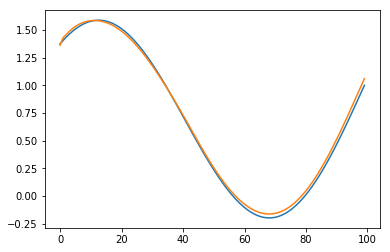

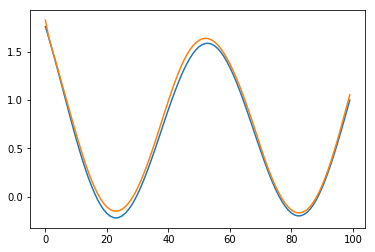

In [378]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])

In [379]:
m = ef.module_
o, q = m(Variable(X_train[0:1]))
vis.heatmap(q[0,:].data.numpy(), win='bar')

'bar'